In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
%load_ext autoreload

In [3]:
%autoreload 2

In [4]:
import seaborn as sns

In [5]:
sns.set_context('poster', font_scale=1.25)

In [6]:
import findspark as fs

In [7]:
fs.init()

In [8]:
import pyspark as ps

In [9]:
import multiprocessing as mp

In [10]:
num_processors = mp.cpu_count()

In [11]:
config = ps.SparkConf()
config = config.setMaster('local[' + str(2*num_processors) + ']')
config = config.setAppName('wiki_solver')
config = config.set('spark.executor.memory','32g')
config = config.set('spark.driver.memory', '32g')

In [12]:
sc = ps.SparkContext(conf=config)

In [13]:
config.get('spark.executor.memory')

u'32g'

In [14]:
sc.getLocalProperty('spark.executor.memory')

# Graph work

In [15]:
links_raw_data = sc.textFile('links-simple-sorted.txt', minPartitions=num_processors*2)
titles_raw_data = sc.textFile('titles-sorted.txt', minPartitions=num_processors*2)

In [16]:
links_raw_data.take(2)

[u'1: 1664968', u'2: 3 747213 1664968 1691047 4095634 5535664']

Ugh. So we need to make a network out of this gigantic dataset. Let's get started. Luckily we can prototype my code locally & deploy on the cluster.

In [17]:
import re

In [18]:
def get_links(x):
    split = re.findall(r"[\w']+", x)
    name = int(split[0])
    linked_to = split[1:]
    linked_to = [int(z) for z in linked_to]
    return (name, linked_to)

In [19]:
all_links = links_raw_data.map(get_links)

In [20]:
all_links.take(2)

[(1, [1664968]), (2, [3, 747213, 1664968, 1691047, 4095634, 5535664])]

Good. This is what we need...it would be better if we could get the titles though. I guess that's not a big deal though. To link to the titles...how do we do that? Probably reduce by key. BLEHHH

We need to remember that the titles are **1-indexed.**

In [21]:
titles_raw_data.take(5)

[u'!', u'!!', u'!!!', u'!!!!', u'!!!Fuck_You!!!']

Ok this is reasonably hilarious. lol. I guess the list was not pruned of innapropriate stuff! :D 

In [22]:
titles_with_index = titles_raw_data.zipWithIndex()

In [23]:
titles_with_index.take(5)

[(u'!', 0), (u'!!', 1), (u'!!!', 2), (u'!!!!', 3), (u'!!!Fuck_You!!!', 4)]

In [24]:
index_then_title = titles_with_index.map(lambda x: (x[1] + 1, x[0])) # Zero indexed!

In [25]:
index_then_title.take(5)

[(1, u'!'), (2, u'!!'), (3, u'!!!'), (4, u'!!!!'), (5, u'!!!Fuck_You!!!')]

In [26]:
network_rdd = all_links

In [27]:
network_rdd.cache()

PythonRDD[10] at RDD at PythonRDD.scala:43

Looks pretty good. Nice.

In [28]:
network_rdd.is_cached

True

If it's cached my computer will explode. Not enough memory :( 

In [29]:
from HW1.network_commands import Path_Finder

We need to look up the start and finish nodes.

In [30]:
start_node = titles_with_index.lookup('Harvard_University')[0]
end_node = titles_with_index.lookup('Kevin_Bacon')[0]

In [31]:
finder = Path_Finder(sc, network_rdd, start_node, end_node)

Great.

In [32]:
finder.run_until_converged()

Py4JJavaError: An error occurred while calling z:org.apache.spark.api.python.PythonRDD.collectAndServe.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 22 in stage 20.0 failed 1 times, most recent failure: Lost task 22.0 in stage 20.0 (TID 670, localhost): java.lang.OutOfMemoryError: Java heap space
	at org.apache.spark.api.python.PythonRDD$$anon$1.read(PythonRDD.scala:113)
	at org.apache.spark.api.python.PythonRDD$$anon$1.next(PythonRDD.scala:101)
	at org.apache.spark.api.python.PythonRDD$$anon$1.next(PythonRDD.scala:97)
	at org.apache.spark.InterruptibleIterator.next(InterruptibleIterator.scala:43)
	at scala.collection.Iterator$GroupedIterator.takeDestructively(Iterator.scala:914)
	at scala.collection.Iterator$GroupedIterator.go(Iterator.scala:929)
	at scala.collection.Iterator$GroupedIterator.fill(Iterator.scala:969)
	at scala.collection.Iterator$GroupedIterator.hasNext(Iterator.scala:972)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:327)
	at org.apache.spark.shuffle.sort.BypassMergeSortShuffleWriter.insertAll(BypassMergeSortShuffleWriter.java:118)
	at org.apache.spark.shuffle.sort.SortShuffleWriter.write(SortShuffleWriter.scala:73)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:73)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:41)
	at org.apache.spark.scheduler.Task.run(Task.scala:88)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:214)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1145)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:615)
	at java.lang.Thread.run(Thread.java:745)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1280)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1268)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1267)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:47)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1267)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:697)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:697)
	at scala.Option.foreach(Option.scala:236)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:697)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:1493)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1455)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1444)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:567)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1813)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1826)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1839)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1910)
	at org.apache.spark.rdd.RDD$$anonfun$collect$1.apply(RDD.scala:905)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:147)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:108)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:306)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:904)
	at org.apache.spark.api.python.PythonRDD$.collectAndServe(PythonRDD.scala:373)
	at org.apache.spark.api.python.PythonRDD.collectAndServe(PythonRDD.scala)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:57)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:606)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:231)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:379)
	at py4j.Gateway.invoke(Gateway.java:259)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:133)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:207)
	at java.lang.Thread.run(Thread.java:745)
Caused by: java.lang.OutOfMemoryError: Java heap space
	at org.apache.spark.api.python.PythonRDD$$anon$1.read(PythonRDD.scala:113)
	at org.apache.spark.api.python.PythonRDD$$anon$1.next(PythonRDD.scala:101)
	at org.apache.spark.api.python.PythonRDD$$anon$1.next(PythonRDD.scala:97)
	at org.apache.spark.InterruptibleIterator.next(InterruptibleIterator.scala:43)
	at scala.collection.Iterator$GroupedIterator.takeDestructively(Iterator.scala:914)
	at scala.collection.Iterator$GroupedIterator.go(Iterator.scala:929)
	at scala.collection.Iterator$GroupedIterator.fill(Iterator.scala:969)
	at scala.collection.Iterator$GroupedIterator.hasNext(Iterator.scala:972)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:327)
	at org.apache.spark.shuffle.sort.BypassMergeSortShuffleWriter.insertAll(BypassMergeSortShuffleWriter.java:118)
	at org.apache.spark.shuffle.sort.SortShuffleWriter.write(SortShuffleWriter.scala:73)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:73)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:41)
	at org.apache.spark.scheduler.Task.run(Task.scala:88)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:214)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1145)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:615)
	... 1 more


Very cool. The nodes are connected. Let's get a path!

In [103]:
path = finder.collected_distance_rdd

Holy crap that's a lot of data. lol

In [121]:
path

[(5505024, (4, [1983501])),
 (917504,
  (4,
   [786872,
    968848,
    983306,
    983317,
    983324,
    1025198,
    1026413,
    1125990,
    1446921,
    1569797,
    1579656,
    1657246,
    1701171,
    1979421,
    2039206,
    2128202,
    2152543,
    2218641,
    2235278,
    2246753,
    2354640,
    2462717,
    2560320,
    2562876,
    2660402,
    2665892,
    2707993,
    2897817,
    2936220,
    3001208,
    3008596,
    3011419,
    3313523,
    3402495,
    3402498,
    3422325,
    3852047,
    3879658,
    3905044,
    4112693,
    4125216,
    4289323,
    4689893,
    4689898,
    4717314,
    4896887,
    5327329,
    5451026])),
 (5267976, (5, [2996659])),
 (3407880,
  (4,
   [497520,
    497525,
    594399,
    748549,
    782903,
    797533,
    2228454,
    2401045,
    2541986,
    3493374,
    4089465,
    4227967,
    4295387,
    5447588])),
 (1811264, (5, [350342, 464807])),
 (2228240, (4, [60071, 3513762, 3550402, 3550408])),
 (5264728, (5, [596661

In [110]:
path_rdd = sc.parallelize(path)

In [115]:
path_rdd.take(1)

[(5505024, (4, [1983501]))]

In [120]:
path_rdd.lookup(end_node)

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server
Traceback (most recent call last):
  File "/home/bryan/apps/spark-1.5.0-bin-hadoop2.6/python/lib/py4j-0.8.2.1-src.zip/py4j/java_gateway.py", line 425, in start
    self.socket.connect((self.address, self.port))
  File "/home/bryan/anaconda/lib/python2.7/socket.py", line 228, in meth
    return getattr(self._sock,name)(*args)
error: [Errno 111] Connection refused


Py4JNetworkError: An error occurred while trying to connect to the Java server

In [118]:
final_node.collect()

Py4JJavaError: An error occurred while calling z:org.apache.spark.api.python.PythonRDD.collectAndServe.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 19 in stage 116.0 failed 1 times, most recent failure: Lost task 19.0 in stage 116.0 (TID 3074, localhost): java.lang.OutOfMemoryError: Java heap space
	at java.lang.reflect.Array.newInstance(Array.java:70)
	at java.io.ObjectInputStream.readArray(ObjectInputStream.java:1670)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1344)
	at java.io.ObjectInputStream.readArray(ObjectInputStream.java:1706)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1344)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:1997)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:1921)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:1798)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1350)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:1997)
	at java.io.ObjectInputStream.defaultReadObject(ObjectInputStream.java:500)
	at org.apache.spark.rdd.ParallelCollectionPartition$$anonfun$readObject$1.apply$mcV$sp(ParallelCollectionRDD.scala:74)
	at org.apache.spark.util.Utils$.tryOrIOException(Utils.scala:1160)
	at org.apache.spark.rdd.ParallelCollectionPartition.readObject(ParallelCollectionRDD.scala:70)
	at sun.reflect.GeneratedMethodAccessor47.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:606)
	at java.io.ObjectStreamClass.invokeReadObject(ObjectStreamClass.java:1017)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:1897)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:1798)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1350)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:1997)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:1921)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:1798)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1350)
	at java.io.ObjectInputStream.readObject(ObjectInputStream.java:370)
	at org.apache.spark.serializer.JavaDeserializationStream.readObject(JavaSerializer.scala:72)
	at org.apache.spark.serializer.JavaSerializerInstance.deserialize(JavaSerializer.scala:98)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:194)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1145)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:615)
	at java.lang.Thread.run(Thread.java:745)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1280)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1268)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1267)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:47)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1267)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:697)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:697)
	at scala.Option.foreach(Option.scala:236)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:697)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:1493)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1455)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1444)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:567)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1813)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1826)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1839)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1910)
	at org.apache.spark.rdd.RDD$$anonfun$collect$1.apply(RDD.scala:905)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:147)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:108)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:306)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:904)
	at org.apache.spark.api.python.PythonRDD$.collectAndServe(PythonRDD.scala:373)
	at org.apache.spark.api.python.PythonRDD.collectAndServe(PythonRDD.scala)
	at sun.reflect.GeneratedMethodAccessor52.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:606)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:231)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:379)
	at py4j.Gateway.invoke(Gateway.java:259)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:133)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:207)
	at java.lang.Thread.run(Thread.java:745)
Caused by: java.lang.OutOfMemoryError: Java heap space
	at java.lang.reflect.Array.newInstance(Array.java:70)
	at java.io.ObjectInputStream.readArray(ObjectInputStream.java:1670)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1344)
	at java.io.ObjectInputStream.readArray(ObjectInputStream.java:1706)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1344)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:1997)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:1921)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:1798)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1350)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:1997)
	at java.io.ObjectInputStream.defaultReadObject(ObjectInputStream.java:500)
	at org.apache.spark.rdd.ParallelCollectionPartition$$anonfun$readObject$1.apply$mcV$sp(ParallelCollectionRDD.scala:74)
	at org.apache.spark.util.Utils$.tryOrIOException(Utils.scala:1160)
	at org.apache.spark.rdd.ParallelCollectionPartition.readObject(ParallelCollectionRDD.scala:70)
	at sun.reflect.GeneratedMethodAccessor47.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:606)
	at java.io.ObjectStreamClass.invokeReadObject(ObjectStreamClass.java:1017)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:1897)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:1798)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1350)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:1997)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:1921)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:1798)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1350)
	at java.io.ObjectInputStream.readObject(ObjectInputStream.java:370)
	at org.apache.spark.serializer.JavaDeserializationStream.readObject(JavaSerializer.scala:72)
	at org.apache.spark.serializer.JavaSerializerInstance.deserialize(JavaSerializer.scala:98)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:194)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1145)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:615)
	... 1 more


# Old stuff

In [19]:
marvel_raw_data.take(10)

[u'"FROST, CARMILLA","AA2 35"',
 u'"KILLRAVEN/JONATHAN R","AA2 35"',
 u'"M\'SHULLA","AA2 35"',
 u'"24-HOUR MAN/EMMANUEL","AA2 35"',
 u'"OLD SKULL","AA2 35"',
 u'"G\'RATH","AA2 35"',
 u'"3-D MAN/CHARLES CHAN","M/PRM 35"',
 u'"3-D MAN/CHARLES CHAN","M/PRM 36"',
 u'"3-D MAN/CHARLES CHAN","M/PRM 37"',
 u'"HUMAN ROBOT","WI? 9"']

In [20]:
def get_issue_character(raw_line):
    dat = raw_line.split('"')
    character_name = dat[1]
    issue = dat[3]
    return (issue, character_name)

In [21]:
issue_character_rdd = marvel_raw_data.map(get_issue_character)

Links are symmetric. We can just create key/value pairs from this. We want character as a key, values as everyone they link to. If one character links to another, the other character *must* link to them!

In [22]:
issue_groups_rdd = issue_character_rdd.groupByKey()

In [23]:
muffin = [(2,3),(4,5)]

In [24]:
def get_links_from_groups(x):
    list_of_characters = list(x[1])
    links = []
    for cur_character in list_of_characters:
        for other_character in list_of_characters:
            if cur_character != other_character:
                # Ensure that links are symmetric
                links.append((cur_character, other_character))
                links.append((other_character, cur_character))
    return tuple(links)

In [25]:
all_links_rdd = issue_groups_rdd.flatMap(get_links_from_groups)

We now groupby key again. And then we have all the links for a given individual. *But* we have to make sure they are unique.

In [26]:
all_links_rdd.take(2)

[(u'PRINCESS ZANDA', u"BLACK PANTHER/T'CHAL"),
 (u"BLACK PANTHER/T'CHAL", u'PRINCESS ZANDA')]

In [27]:
character_and_links_rdd = all_links_rdd.groupByKey()

In [28]:
def cleanup_links(x):
    linked_to = list(x[1])
    unique_links = tuple(set(linked_to))
    return (x[0], unique_links)

In [29]:
character_and_links_rdd.take(1)

[(u'QUESADA, JOE', <pyspark.resultiterable.ResultIterable at 0x7fb35ff868d0>)]

In [30]:
network_rdd = character_and_links_rdd.map(cleanup_links)

Ok, awesome. We are all set.

In [31]:
network_result = network_rdd.collect()

In [32]:
network_result[0:5]

[(u'QUESADA, JOE',
  (u'ZURI',
   u'GLADIATOR/MELVIN POT',
   u'SMITH, KEVIN',
   u'OKOYE',
   u'PALMIOTTI, JIMMY',
   u'MARTINEZ, ALITHA',
   u'MYSTERIO/QUENTIN BEC',
   u'WATSON-PARKER, MARY ',
   u'SPIDER-MAN/PETER PAR',
   u'MCKENZIE, LYDIA',
   u'LAMY, KELLY',
   u'URICH, BEN',
   u"BLACK PANTHER/T'CHAL",
   u'MR. FANTASTIC/REED R',
   u'THING/BENJAMIN J. GR',
   u'QUINN, ASHLEY',
   u'CAPTAIN AMERICA',
   u'MALICE V/NAKIA',
   u'NELSON, CANDACE',
   u'INVISIBLE WOMAN/SUE ',
   u'BUTCH',
   u'EIGHTBALL',
   u'DAREDEVIL/MATT MURDO',
   u'ROSS, EVERETT KENNET',
   u'POTTER, BETSY BEATTY',
   u'BLACK WIDOW/NATASHA ',
   u'EVERETT, BILL',
   u'BLAKE, BECKY',
   u'DAKESIAN, NANCI',
   u'SHARPE, ROSALINDE',
   u'NELSON, FRANKLIN FOG',
   u'MILLER, FRANK',
   u'HUMAN TORCH/JOHNNY S',
   u'OSBORN, LIZ ALLAN',
   u'DR. STRANGE/STEPHEN ',
   u'DARLA',
   u'RALF',
   u'PAGE, KAREN',
   u'LEE, STAN')),
 (u'CRUSADER II/ARTHUR B',
  (u'HELA [ASGARDIAN]',
   u'X-MAN/NATHAN GREY ',
   u'HOGUN [AS

## One iteration

In [33]:
start_node = 'CAPTAIN AMERICA'

In [34]:
network_to_touch = network_rdd.filter(lambda x: x[0] == start_node)
print network_to_touch.take(1)

[(u'CAPTAIN AMERICA', (u'QUESADA, JOE', u'SILVER SAMURAI/KENYU', u'CAPTAIN AMERICA IV/S', u'DREAMING CELESTIAL/T', u'VOGHT, AMELIA', u'KRO [DEVIANT]', u'PHASTOS [ETERNAL]', u'PUCK DOPPELGANGER', u'POPE', u'POWER PRINCESS/ZARDA', u'MODRED THE MYSTIC', u"JACK O'LANTERN II/MA", u'DR. FAUSTUS', u'GHOST GIRL/', u'HESCAMAR/MARNOT [ASG', u'LORD TEMPLAR/', u'RODGERS, MARIANNE', u'HIJACKER', u'HOCHBERG, ROGER', u'MARROW/SARAH ', u'EPOCH', u'MOTHER NIGHT/SUSAN S', u'PIECEMEAL/GILBERT BE', u'OMNIBUS/LT. DALLAS', u'SHAKTI', u'WHIZZER III/JAMES SA', u'KORATH THE PURSUER', u'WOLFE, HEDY', u'WOLF SPIRIT/OWAYODAT', u'PEREGRINE, LE/FRANCK', u'STRUCKER, ANDREA', u'MARTHA', u'MAGUS', u'DOLLAR BILL', u'MANTIS/? BRANDT', u'CARBON', u'KNIGHT ERRANT/MATSON', u'STUNT-MASTER/GEORGE ', u'NEKRA/ADRIENNE HATRO', u'WHITMAN, DEBRA', u'BRADDOCK, JAMES JR. ', u'DUNER, MAJOR', u'ACHEBE, REVEREND DOC', u'MALICE V/NAKIA', u'BERDITCHEV, ITZHAK', u'SANTINI, DR. JOSE', u'PIPER', u'CAT MAN III/', u'JAMESON, J. JONAH', u'CAP

In [35]:
distance_rdd = network_to_touch.map(lambda x: (x[0], 0))

In [36]:
nodes_to_touch = network_to_touch.flatMap(lambda x: x[1])

In [37]:
unique_nodes_to_touch = nodes_to_touch.distinct()

Now append these to the distance_rdd. 

In [38]:
updated_touched_nodes = unique_nodes_to_touch.map(lambda x: (x, 1))

In [39]:
updated_touched_nodes.take(5)

[(u'QUESADA, JOE', 1),
 (u'PARKER, MAY | TIMESL', 1),
 (u'SILVER SAMURAI/KENYU', 1),
 (u'STORM, CHILI', 1),
 (u'JESTER III', 1)]

In [40]:
updated_distance_rdd = distance_rdd.union(updated_touched_nodes)

In [41]:
updated_distance_rdd.take(5)

[(u'CAPTAIN AMERICA', 0),
 (u'QUESADA, JOE', 1),
 (u'PARKER, MAY | TIMESL', 1),
 (u'SILVER SAMURAI/KENYU', 1),
 (u'STORM, CHILI', 1)]

We now reduce by key!

In [42]:
def get_smaller_value(a, b):
    if a < b:
        return a
    else:
        return b

In [43]:
corrected_distance_rdd = updated_distance_rdd.reduceByKey(get_smaller_value)

In [44]:
muffin = corrected_distance_rdd.collectAsMap()

Now we have to apply this a bunch of times. Then we are all set. The piece I was missing was reduce by key.

Let's make a class to handle this. Let's make that class in a separate file and import it or it's going to be very annoying.

Also, let's figure out how to join the distance rdd to what we need.

In [45]:
already_touched_rdd = corrected_distance_rdd.map(lambda x: x[0])
already_touched = already_touched_rdd.collect()

In [46]:
already_touched_set = set(already_touched)

In [47]:
broadcasted_touched = sc.broadcast(already_touched_set)

In [48]:
network_to_touch = network_rdd.filter(lambda x: x[0] in broadcasted_touched.value)

This is a good way to do it and avoids a nasty join.

# Applying my class

This makes no sense. Can we run the eval function instead of importing...?

In [94]:
from BFS import BFS

## Captain America

In [62]:
searcher = BFS(sc, 'CAPTAIN AMERICA', network_rdd)

In [63]:
for i in range(10):
    searcher.do_iteration()

In [65]:
captain_america_result = searcher.collected_distance_rdd

In [68]:
muffin = dict(captain_america_result)

(array([  1.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          1.90600000e+03,   0.00000000e+00,   0.00000000e+00,
          4.46300000e+03,   0.00000000e+00,   0.00000000e+00,
          3.80000000e+01]),
 array([ 0. ,  0.3,  0.6,  0.9,  1.2,  1.5,  1.8,  2.1,  2.4,  2.7,  3. ]),
 <a list of 10 Patch objects>)

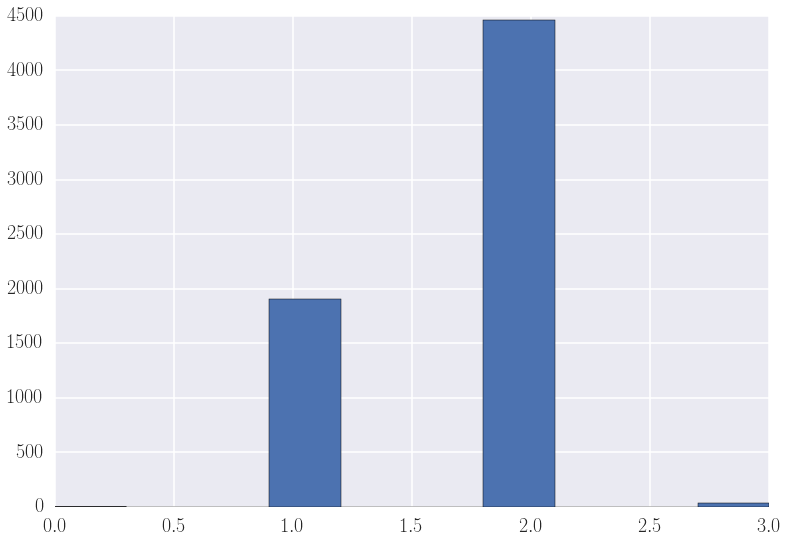

In [71]:
plt.hist(muffin.values())

Cool. The number of nodes touched are

In [72]:
len(muffin)

6408

## Miss Thing/Mary

In [73]:
searcher = BFS(sc, 'MISS THING/MARY', network_rdd)

In [74]:
for i in range(10):
    searcher.do_iteration()

In [75]:
thing_list = searcher.collected_distance_rdd

In [77]:
muffin = dict(thing_list)

(array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  6.]),
 array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ]),
 <a list of 10 Patch objects>)

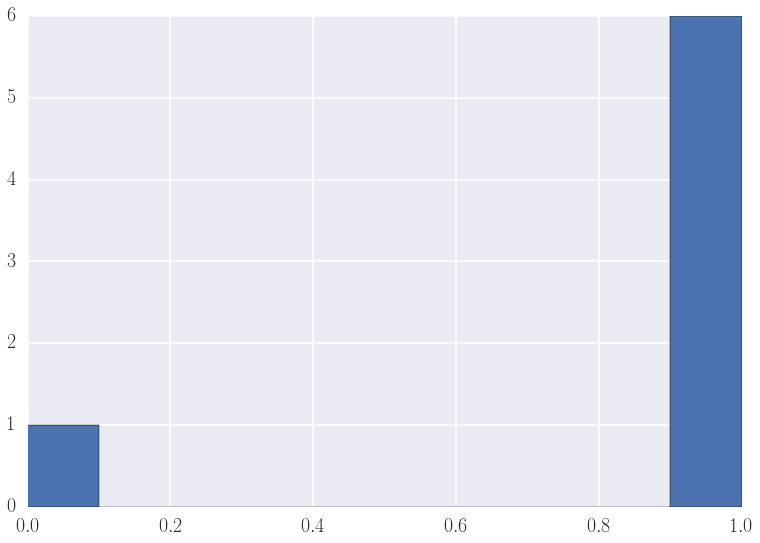

In [78]:
plt.hist(muffin.values())

In [79]:
len(muffin)

7

## Orwell

In [80]:
searcher = BFS(sc, 'ORWELL', network_rdd)

In [81]:
for i in range(10):
    searcher.do_iteration()

In [82]:
orwell_list = searcher.collected_distance_rdd

In [84]:
muffin = dict(orwell_list)

(array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  8.]),
 array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ]),
 <a list of 10 Patch objects>)

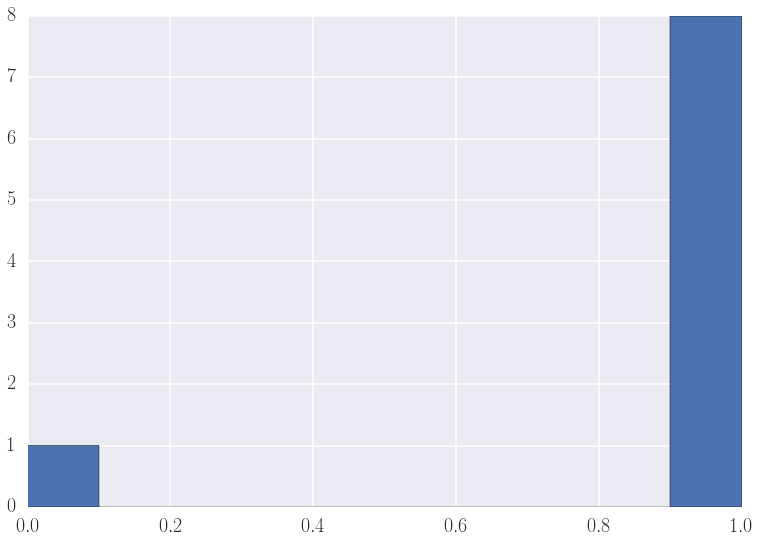

In [85]:
plt.hist(muffin.values())

In [86]:
len(orwell_list)

9

In [87]:
orwell_list

[(u'NILES, SEN. CATHERIN', 1),
 (u'ASHER, CARL', 1),
 (u'LUDLUM, ROSS', 1),
 (u'ASHER, MICHAEL', 1),
 (u'ORWELL', 0),
 (u'OSWALD', 1),
 (u'FAGIN', 1),
 (u'HOFFMAN', 1),
 (u'ASHER, DONNA', 1)]

Well, I think this is the first part of the problem. I don't really understand how to optimize with accumulators though. Also, let us write code to make the network converge.

In [113]:
network_rdd = network_rdd.cache()

In [116]:
network_rdd.is_cached

True

# Running until converged

In [117]:
searcher = BFS(sc, 'CAPTAIN AMERICA', network_rdd)

In [118]:
searcher.run_until_converged()

Finished at end of iteration 4 !


In [103]:
searcher = BFS(sc, 'ORWELL', network_rdd)

In [104]:
searcher.run_until_converged()

Finished at end of iteration 2 !


In [92]:
a={'a':1, 'b':2, 'c':3}
b = {'c':2, 'b':2, 'a':1, 'd':69}

In [ ]:
assert cmp